<a href="https://colab.research.google.com/github/HarshavardhanBhupathi/Data-science/blob/main/Customer_churn_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CUSTOMER CHURN CLASSIFICATION USING XGBOOST ALGORITHM

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score,balanced_accuracy_score,make_scorer

In [ ]:
cc=pd.read_excel(r"/home/CustomerChurn.xlsx")

In [ ]:
cc

,LoyaltyID,Customer ID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
0,318537,7590-VHVEG,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,152148,5575-GNVDE,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,326527,3668-QPYBK,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,845894,7795-CFOCW,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,503388,9237-HQITU,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,810338,6840-RESVB,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,230811,2234-XADUH,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,155157,4801-JZAZL,No,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,731782,8361-LTMKD,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [ ]:
cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   LoyaltyID          7043 non-null   int64  
 1   Customer ID        7043 non-null   object 
 2   Senior Citizen     7043 non-null   object 
 3   Partner            7043 non-null   object 
 4   Dependents         7043 non-null   object 
 5   Tenure             7043 non-null   int64  
 6   Phone Service      7043 non-null   object 
 7   Multiple Lines     7043 non-null   object 
 8   Internet Service   7043 non-null   object 
 9   Online Security    7043 non-null   object 
 10  Online Backup      7043 non-null   object 
 11  Device Protection  7043 non-null   object 
 12  Tech Support       7043 non-null   object 
 13  Streaming TV       7043 non-null   object 
 14  Streaming Movies   7043 non-null   object 
 15  Contract           7043 non-null   object 
 16  Paperless Billing  7043 

In [ ]:
cc.isnull().sum()

LoyaltyID            0
Customer ID          0
Senior Citizen       0
Partner              0
Dependents           0
Tenure               0
Phone Service        0
Multiple Lines       0
Internet Service     0
Online Security      0
Online Backup        0
Device Protection    0
Tech Support         0
Streaming TV         0
Streaming Movies     0
Contract             0
Paperless Billing    0
Payment Method       0
Monthly Charges      0
Total Charges        0
Churn                0
dtype: int64

In [ ]:
cc.shape

(7043, 21)

In [ ]:
cc.loc[cc['Total Charges']==' ']

,LoyaltyID,Customer ID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
488,344543,4472-LVYGI,No,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,150036,3115-CZMZD,No,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,497688,5709-LVOEQ,No,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,158969,4367-NUYAO,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,470044,1371-DWPAZ,No,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,937662,7644-OMVMY,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,821083,3213-VVOLG,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,947028,2520-SGTTA,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,135257,2923-ARZLG,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,317862,4075-WKNIU,No,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [ ]:
cc.loc[(cc['Total Charges']==' '),'Total Charges']=0 ##converting empty values into 0's

In [ ]:
cc['Total Charges']=pd.to_numeric(cc['Total Charges'])

In [ ]:
cc.dtypes

LoyaltyID              int64
Customer ID           object
Senior Citizen        object
Partner               object
Dependents            object
Tenure                 int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges        float64
Churn                 object
dtype: object

In [ ]:
cc['Senior Citizen'].unique()

array(['No', 'Yes'], dtype=object)

In [ ]:
cc['Contract'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [ ]:
cc.replace(' ','_',regex=True,inplace=True) ##just for Xgboost tree display

In [ ]:
cc

,LoyaltyID,Customer ID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
0,318537,7590-VHVEG,No,Yes,No,1,No,No_phone_service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic_check,29.85,29.85,No
1,152148,5575-GNVDE,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One_year,No,Mailed_check,56.95,1889.50,No
2,326527,3668-QPYBK,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,Yes
3,845894,7795-CFOCW,No,No,No,45,No,No_phone_service,DSL,Yes,No,Yes,Yes,No,No,One_year,No,Bank_transfer_(automatic),42.30,1840.75,No
4,503388,9237-HQITU,No,No,No,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,810338,6840-RESVB,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One_year,Yes,Mailed_check,84.80,1990.50,No
7039,230811,2234-XADUH,No,Yes,Yes,72,Yes,Yes,Fiber_optic,No,Yes,Yes,No,Yes,Yes,One_year,Yes,Credit_card_(automatic),103.20,7362.90,No
7040,155157,4801-JZAZL,No,Yes,Yes,11,No,No_phone_service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic_check,29.60,346.45,No
7041,731782,8361-LTMKD,Yes,Yes,No,4,Yes,Yes,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed_check,74.40,306.60,Yes


In [ ]:
cc.columns

Index(['LoyaltyID', 'Customer ID', 'Senior Citizen', 'Partner', 'Dependents',
       'Tenure', 'Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charges', 'Total Charges', 'Churn'],
      dtype='object')

Splitting data into x and y; where the columns in x  used tomake classifications and column y which is to be predicted.

In [ ]:
x=cc.drop(['Churn','LoyaltyID','Customer ID'],axis=1)

In [ ]:
x.columns

Index(['Senior Citizen', 'Partner', 'Dependents', 'Tenure', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges'],
      dtype='object')

In [ ]:
y=cc['Churn']

Its important to use One -hot encoding on categorical variables to make it look like continous variables 

In [ ]:
x.dtypes 

Senior Citizen        object
Partner               object
Dependents            object
Tenure                 int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges        float64
dtype: object

In [ ]:
x['Senior Citizen'].unique()

array(['No', 'Yes'], dtype=object)

In [ ]:
x['Partner'].unique()



array(['Yes', 'No'], dtype=object)

In [ ]:
x['Dependents'].unique()

array(['No', 'Yes'], dtype=object)

In [ ]:
x['Paperless Billing'].unique()

array(['Yes', 'No'], dtype=object)

In [ ]:
x['Phone Service'].unique()

array(['No', 'Yes'], dtype=object)

In [ ]:
x['Multiple Lines'].unique()

array(['No_phone_service', 'No', 'Yes'], dtype=object)

In [ ]:
x['Internet Service'].unique()

array(['DSL', 'Fiber_optic', 'No'], dtype=object)

In [ ]:
x['Online Backup'].unique()

array(['Yes', 'No', 'No_internet_service'], dtype=object)

In [ ]:
x['Online Security'].unique()

array(['No', 'Yes', 'No_internet_service'], dtype=object)

In [ ]:
x['Device Protection'].unique()

array(['No', 'Yes', 'No_internet_service'], dtype=object)

In [ ]:
x['Payment Method'].unique()

array(['Electronic_check', 'Mailed_check', 'Bank_transfer_(automatic)',
       'Credit_card_(automatic)'], dtype=object)

In [ ]:
x['Tech Support'].unique()

array(['No', 'Yes', 'No_internet_service'], dtype=object)

In [ ]:
x['Streaming Movies'].unique()

array(['No', 'Yes', 'No_internet_service'], dtype=object)

In [ ]:
x['Streaming TV'].unique()

array(['No', 'Yes', 'No_internet_service'], dtype=object)

In [ ]:
x=pd.get_dummies(x,columns=['Senior Citizen','Partner','Dependents','Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',])

In [ ]:
x.dtypes

Tenure                                        int64
Monthly Charges                             float64
Total Charges                               float64
Senior Citizen_No                             uint8
Senior Citizen_Yes                            uint8
Partner_No                                    uint8
Partner_Yes                                   uint8
Dependents_No                                 uint8
Dependents_Yes                                uint8
Phone Service_No                              uint8
Phone Service_Yes                             uint8
Multiple Lines_No                             uint8
Multiple Lines_No_phone_service               uint8
Multiple Lines_Yes                            uint8
Internet Service_DSL                          uint8
Internet Service_Fiber_optic                  uint8
Internet Service_No                           uint8
Online Security_No                            uint8
Online Security_No_internet_service           uint8
Online Secur

In [ ]:
x.head()

,Tenure,Monthly Charges,Total Charges,Senior Citizen_No,Senior Citizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,Phone Service_No,Phone Service_Yes,Multiple Lines_No,Multiple Lines_No_phone_service,Multiple Lines_Yes,Internet Service_DSL,Internet Service_Fiber_optic,Internet Service_No,Online Security_No,Online Security_No_internet_service,Online Security_Yes,Online Backup_No,Online Backup_No_internet_service,Online Backup_Yes,Device Protection_No,Device Protection_No_internet_service,Device Protection_Yes,Tech Support_No,Tech Support_No_internet_service,Tech Support_Yes,Streaming TV_No,Streaming TV_No_internet_service,Streaming TV_Yes,Streaming Movies_No,Streaming Movies_No_internet_service,Streaming Movies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,Paperless Billing_No,Paperless Billing_Yes,Payment Method_Bank_transfer_(automatic),Payment Method_Credit_card_(automatic),Payment Method_Electronic_check,Payment Method_Mailed_check
0,1,29.85,29.85,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
1,34,56.95,1889.50,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1
2,2,53.85,108.15,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
3,45,42.30,1840.75,1,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0
4,2,70.70,151.65,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0


In [ ]:
y.unique()

array(['No', 'Yes'], dtype=object)

In [ ]:
y

0        No
1        No
2       Yes
3        No
4       Yes
       ... 
7038     No
7039     No
7040     No
7041    Yes
7042     No
Name: Churn, Length: 7043, dtype: object

In [ ]:
y=y.replace(['Yes','No'],['1','0'])

In [ ]:
y=y.astype(int)

In [ ]:
y

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7043, dtype: int64

In [ ]:
sum(y)

1869

In [ ]:
sum(y)/len(y)

0.2653698707936959

Here we can observe that around 27 % of customers who left or disconnected with the company 

So to maintain this percentage during training and splitting we use stratify attribute 

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=42,stratify=y)

Building Premilinary Model

In [ ]:
xgbcl=xb.XGBClassifier(objective="binary:logistic",missing=None,seed=42)

We gonna use early stopping attribute to stop building tree when there is no longer optimisation rather defining optimal number of trees with CV

In [ ]:
xgbcl.fit(x_train,y_train,verbose=True,early_stopping_rounds=10,eval_metric='aucpr',eval_set=[(x_test,y_test)])

[0]	validation_0-aucpr:0.579067
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.581273
[2]	validation_0-aucpr:0.594607
[3]	validation_0-aucpr:0.595215
[4]	validation_0-aucpr:0.596482
[5]	validation_0-aucpr:0.598574
[6]	validation_0-aucpr:0.631769
[7]	validation_0-aucpr:0.638008
[8]	validation_0-aucpr:0.638729
[9]	validation_0-aucpr:0.63937
[10]	validation_0-aucpr:0.63839
[11]	validation_0-aucpr:0.641466
[12]	validation_0-aucpr:0.641945
[13]	validation_0-aucpr:0.641556
[14]	validation_0-aucpr:0.640274
[15]	validation_0-aucpr:0.64372
[16]	validation_0-aucpr:0.645566
[17]	validation_0-aucpr:0.645732
[18]	validation_0-aucpr:0.647367
[19]	validation_0-aucpr:0.64633
[20]	validation_0-aucpr:0.647219
[21]	validation_0-aucpr:0.647022
[22]	validation_0-aucpr:0.647085
[23]	validation_0-aucpr:0.649197
[24]	validation_0-aucpr:0.650565
[25]	validation_0-aucpr:0.649892
[26]	validation_0-aucpr:0.649925
[27]	validation_0-aucpr:0.649745
[28]	validation_0-aucpr:

XGBClassifier(seed=42)

In [ ]:
## Lets perform on Testing Dataset and Display Confusion Matrix|

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


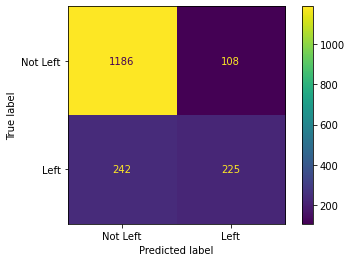

In [ ]:
plot_confusion_matrix(xgbcl,x_test,y_test,display_labels=['Not Left','Left'])

SO from the above matrix, We could see that out of 1294 people who are connected with company , 1178 i.e which is around 91% were correctly classified by our model. Similarly out of 467 who left,225 were correctly classified which is <50% correctly classified .
So due to data imbalance XgBoost doesnot look great here. AS we can see in the data.But whats more important is more efficient  predictions on people who left as it going to cost lot of factors for a company. So xgboost has another surprise for us.Its **Scale_pos_weight** which deals with imbalanced data.

Lets optimize parameters using Cross Validation